## 1. Library Import

In [1]:
# Visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import matplotlib.style as style
%matplotlib inline

# 폰트 경로 설정
font_path = './H2PORL.TTF'

# 폰트 프로퍼티 설정 및 기본 폰트 변경
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()  
plt.rcParams['font.family'] = 'Malgun Gothic'  # 시스템에 따라 적절한 폰트로 변경
plt.style.use('seaborn-poster')
plt.style.use('fivethirtyeight')

# Utilities
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance


## 2. Data Load

#### 2.1. 데이터 로드

In [2]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
dt = pd.read_csv('./train.csv')
dt_test = pd.read_csv('./test.csv')

In [3]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [4]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


In [5]:
dt.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

In [6]:
dt.describe()

,본번,부번,전용면적(㎡),계약년월,계약일,층,건축년도,해제사유발생일,단지소개기존clob,k-전체동수,...,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,건축면적,주차대수,좌표X,좌표Y,target
count,1.118747e+06,1.118747e+06,1.118822e+06,1.118822e+06,1.118822e+06,1.118822e+06,1.118822e+06,5.983000e+03,68582.000000,248192.000000,...,249259.000000,249214.000000,249214.000000,249214.000000,327.0,2.491080e+05,249108.000000,249152.000000,249152.000000,1.118822e+06
mean,5.649108e+02,5.978885e+00,7.717475e+01,2.014760e+05,1.580656e+01,8.871968e+00,1.998755e+03,2.021057e+07,541.529979,14.798346,...,120726.487549,477.912838,476.713439,167.528470,70.0,1.895070e+05,1063.678778,126.995228,37.545785,5.799153e+04
std,5.160642e+02,4.668584e+01,2.936423e+01,4.187868e+02,8.721166e+00,5.982584e+00,9.333908e+00,1.060697e+04,751.809853,17.693533,...,129020.276480,759.909400,727.553569,248.928143,0.0,1.729027e+06,1235.437604,0.091045,0.052483,4.642602e+04
min,0.000000e+00,0.000000e+00,1.002000e+01,2.007010e+05,1.000000e+00,-4.000000e+00,1.961000e+03,2.020022e+07,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,70.0,0.000000e+00,0.000000,126.798318,37.447843,3.500000e+02
25%,1.760000e+02,0.000000e+00,5.965000e+01,2.011100e+05,8.000000e+00,4.000000e+00,1.992000e+03,2.020082e+07,4.000000,5.000000,...,40735.000000,48.000000,95.000000,0.000000,70.0,0.000000e+00,315.000000,126.913157,37.499201,3.050000e+04
50%,4.700000e+02,0.000000e+00,8.188000e+01,2.015070e+05,1.600000e+01,8.000000e+00,2.000000e+03,2.021030e+07,174.000000,10.000000,...,78125.000000,225.000000,256.000000,63.000000,70.0,1.710550e+03,683.000000,127.014971,37.544936,4.480000e+04
75%,7.810000e+02,1.000000e+00,8.496000e+01,2.018040e+05,2.300000e+01,1.200000e+01,2.005000e+03,2.022021e+07,725.000000,17.000000,...,159544.000000,576.000000,582.000000,237.000000,70.0,8.414210e+03,1274.000000,127.059590,37.577117,6.980000e+04
max,4.974000e+03,2.837000e+03,4.243200e+02,2.023060e+05,3.100000e+01,6.900000e+01,2.023000e+03,2.023093e+07,2888.000000,124.000000,...,969877.000000,4975.000000,5132.000000,1500.000000,70.0,3.159620e+07,12096.000000,127.179998,37.687725,1.450000e+06


In [7]:
## 결측치 데이터 백분율 계산 후 소수점 두 자리 까지 반올림
round(dt.isnull().sum() / dt.shape[0] * 100.00, 2).sort_values(ascending = False)

k-135㎡초과                  99.97
해제사유발생일                   99.47
k-등록일자                    99.02
단지소개기존clob                93.87
k-홈페이지                    89.88
고용보험관리번호                  81.63
세대전기계약방법                  78.54
k-팩스번호                    78.01
청소비관리형태                   77.87
k-시행사                     77.87
k-건설사(시공사)                77.85
경비비관리형태                   77.85
k-단지분류(아파트,주상복합등등)        77.82
k-전체동수                    77.82
단지승인일                     77.79
k-전화번호                    77.78
k-복도유형                    77.75
건축면적                      77.73
좌표X                       77.73
k-수정일자                    77.73
좌표Y                       77.73
단지신청일                     77.73
주차대수                      77.73
k-85㎡~135㎡이하              77.73
k-전용면적별세대현황(60㎡~85㎡이하)    77.73
k-전용면적별세대현황(60㎡이하)        77.73
k-사용검사일-사용승인일             77.73
k-주거전용면적                  77.73
k-관리비부과면적                 77.72
기타/의무/임대/임의=1/2/3/4       77.72
k-연면적                     77.72
사용허가여부  

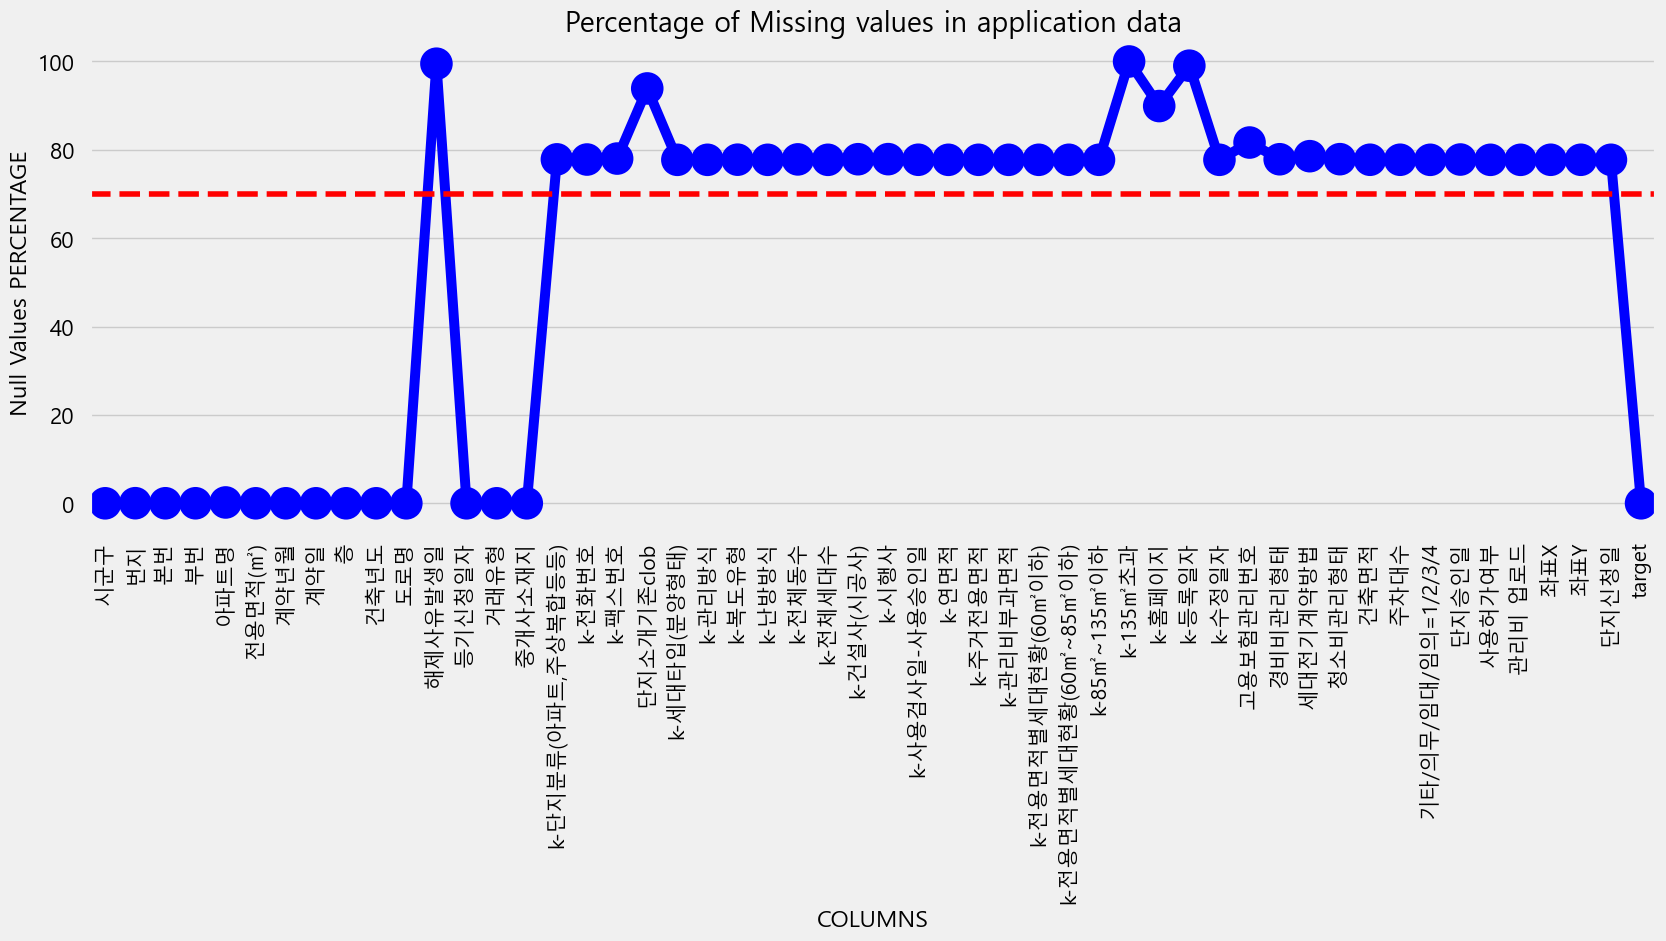

In [8]:
null_applicationDF = pd.DataFrame(dt.isnull().sum() *  100 / dt.shape[0]).reset_index()
null_applicationDF.columns = ['Column Name', 'Null Values Percentage']
fig = plt.figure(figsize = (18,6))
ax = sns.pointplot(x="Column Name", y="Null Values Percentage", data = null_applicationDF, color = 'blue')
plt.xticks(rotation = 90, fontsize = 15)
ax.axhline(70, ls='--', color='red')
plt.title("Percentage of Missing values in application data")
plt.ylabel("Null Values PERCENTAGE")
plt.xlabel("COLUMNS")
plt.show()

## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [9]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [10]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [11]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [12]:
# 칼럼 개수에 따른 그래프 그리기 함수
def plot_value_counts(data, column_name, figsize=(10, 8), title='Value Counts'):
    # 값 개수 세기
    value_counts = data[column_name].value_counts()
    
    # 시각화
    plt.figure(figsize=figsize)
    sns.barplot(x=value_counts, y=value_counts.index)
    plt.title(title)
    plt.xlabel('Counts')
    plt.ylabel(column_name)
    
    plt.show()

In [13]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
# 아래 3가지의 경우 모두 아무 의미도 갖지 않는 element가 포함되어 있습니다.
pd.set_option('display.max_rows', None)
concat['등기신청일자'].value_counts()

            1111271
20230630        585
20230831        496
20230428        394
20230731        374
20230530        367
20230728        357
20230915        326
20230830        310
20230531        305
20230825        244
20230526        231
20230828        209
20230920        208
20230331        200
20230714        200
20230908        198
20230818        197
20230519        191
20230727        187
20230810        180
20230720        172
20230901        171
20230710        169
20230525        168
20230814        164
20230602        153
20230811        153
20230615        153
20230502        148
20230609        148
20230725        146
20230904        144
20230620        139
20230707        139
20230427        138
20230816        138
20230821        132
20230918        131
20230914        131
20230512        125
20230721        125
20230605        125
20230726        124
20230703        124
20230824        123
20230817        123
20230616        122
20230629        121
20230911        119


In [14]:
#등기신청일자 월별로만 보기
concat['등기신청일자'] = concat['등기신청일자'].astype(str)

#연도와 월을 추출하여 새로운 컬럼에 저장
concat['등기신청일자'] = concat['등기신청일자'].str.slice(0, 6)


In [15]:
display(concat['등기신청일자'].value_counts())

          1111271
202308       3183
202307       2872
202305       2626
202306       2624
202309       2111
202304       1675
202303       1141
202302        452
202301        139
Name: 등기신청일자, dtype: int64

In [16]:
display(concat['거래유형'].value_counts())

-       1086451
중개거래      38123
직거래        3520
Name: 거래유형, dtype: int64

In [17]:
# '중개사소재지' 컬럼에서 쉼표(,)가 있는 경우 '전'으로 변경
concat['중개사소재지'] = concat['중개사소재지'].apply(lambda x: x.split(',')[0])

In [18]:
display(concat['중개사소재지'].value_counts())

-             1090013
서울 강남구           3023
서울 노원구           2830
서울 송파구           2590
서울 강동구           2223
서울 강서구           1916
서울 서초구           1860
서울 마포구           1753
서울 성북구           1753
서울 구로구           1750
서울 동대문구          1726
서울 영등포구          1724
서울 양천구           1566
서울 성동구           1520
서울 은평구           1443
서울 동작구           1344
서울 서대문구          1333
서울 도봉구           1286
서울 관악구           1146
서울 중랑구            936
서울 광진구            767
서울 강북구            721
서울 금천구            609
서울 용산구            583
서울 중구             479
서울 종로구            334
경기 하남시            107
경기 성남수정구           67
경기 광명시             64
경기 부천시             60
경기 성남분당구           56
경기 남양주시            53
경기 고양덕양구           44
경기 의정부시            29
경기 용인수지구           23
경기 안양동안구           21
경기 화성시             21
경기 수원영통구           20
경기 구리시             17
경기 의왕시             16
경기 성남중원구           15
경기 김포시             15
인천 서구              14
경기 시흥시             13
경기 안양만안구           13
경기 고양일산서구 

In [19]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [20]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

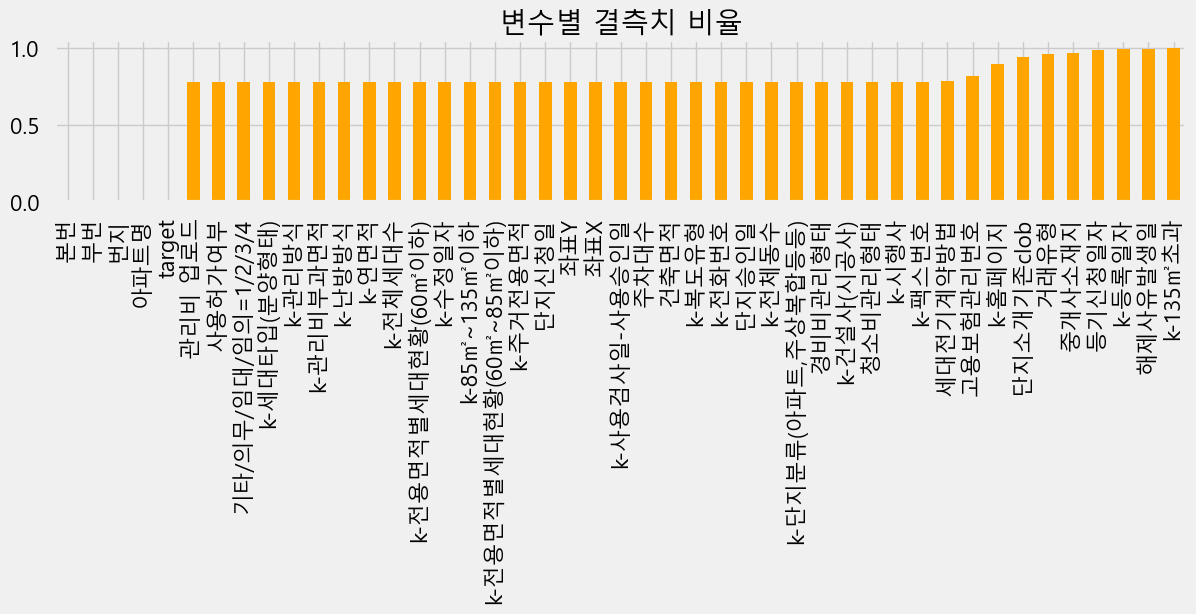

In [21]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [22]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.

print('* 결측치가 100만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 100만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


In [23]:
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
concat_select = concat[selected]

In [24]:
concat.shape, concat_select.shape

((1128094, 53), (1128094, 45))

In [25]:
concat_select.isnull().sum()     # 결측치가 100만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.

# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

시군구                            0
번지                           227
본번                            75
부번                            75
아파트명                        2136
전용면적                           0
계약년월                           0
계약일                            0
층                              0
건축년도                           0
도로명                            0
k-단지분류(아파트,주상복합등등)        877273
k-전화번호                    876850
k-팩스번호                    879348
k-세대타입(분양형태)              876125
k-관리방식                    876125
k-복도유형                    876454
k-난방방식                    876125
k-전체동수                    877207
k-전체세대수                   876125
k-건설사(시공사)                877637
k-시행사                     877834
k-사용검사일-사용승인일             876259
k-연면적                     876125
k-주거전용면적                  876170
k-관리비부과면적                 876125
k-전용면적별세대현황(60㎡이하)        876170
k-전용면적별세대현황(60㎡~85㎡이하)    876170
k-85㎡~135㎡이하              876170
k-수정일자                    876170
고용보험관리번호  

In [26]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 "unknown"이라고 임의로 보간해 주겠습니다.

concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 45 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  k-단지분류(아파트,주상복합등등)      250821 non-null   object 
 12  k-전화번호                  251244 non-null   object 
 13  k-팩스번호                  248746 non-null   object 
 14  k-세대타

In [27]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [28]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [29]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

In [30]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

시군구                            0
번지                             0
본번                             0
부번                             0
아파트명                           0
전용면적                           0
계약년월                           0
계약일                            0
층                              0
건축년도                           0
도로명                            0
k-단지분류(아파트,주상복합등등)             0
k-전화번호                         0
k-팩스번호                         0
k-세대타입(분양형태)                   0
k-관리방식                         0
k-복도유형                         0
k-난방방식                         0
k-전체동수                    877207
k-전체세대수                   876125
k-건설사(시공사)                     0
k-시행사                          0
k-사용검사일-사용승인일                  0
k-연면적                     876125
k-주거전용면적                  876170
k-관리비부과면적                 876125
k-전용면적별세대현황(60㎡이하)        876170
k-전용면적별세대현황(60㎡~85㎡이하)    876170
k-85㎡~135㎡이하              876170
k-수정일자                         0
고용보험관리번호  

In [31]:
# 수치형 데이터 null값 있는 것들 삭제
# target 컬럼을 제외한 나머지 컬럼에서 결측치가 있는 컬럼 찾기
cols_with_missing = concat_select.drop(columns=['target']).isnull().sum()

# 결측치가 있는 컬럼 이름 추출
cols_to_drop = cols_with_missing[cols_with_missing > 0].index

# 해당 컬럼 삭제
concat_select_cleaned = concat_select.drop(columns=cols_to_drop)


In [32]:
# # 연속형 변수에 대한 보간 (선형 보간)
# concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [33]:
concat_select_cleaned.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

시군구                       0
번지                        0
본번                        0
부번                        0
아파트명                      0
전용면적                      0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
k-단지분류(아파트,주상복합등등)        0
k-전화번호                    0
k-팩스번호                    0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-건설사(시공사)                0
k-시행사                     0
k-사용검사일-사용승인일             0
k-수정일자                    0
고용보험관리번호                  0
경비비관리형태                   0
세대전기계약방법                  0
청소비관리형태                   0
기타/의무/임대/임의=1/2/3/4       0
단지승인일                     0
사용허가여부                    0
관리비 업로드                   0
단지신청일                     0
target                 9272
is_test                   0
dtype: int64

In [34]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select_cleaned.shape)

(1128094, 33)


In [35]:
concat_select_cleaned.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)',
       'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', 'target',
       'is_test'],
      dtype='object')

In [36]:
concat_select_cleaned.shape

(1128094, 33)

## 5. Model Training

In [37]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select_cleaned.query('is_test==0')
dt_test = concat_select_cleaned.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118822, 32) (9272, 32)


In [38]:
dt_test.head(1)

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,NULL,직영,단일계약,직영,임의,2022-11-17 13:00:29.0,Y,N,2022-11-17 10:19:06.0,NaN


In [39]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
# 레이블 인코딩은 트리모델에서는 크게 영향을 미치지 않음!
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'target']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']


In [40]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 26/26 [00:08<00:00,  3.12it/s]


In [41]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,단지신청일,target
0,0,4732,1149,1,328,79.97,201712,8,3,1987,...,526,4,1,4,4,725,1,0,249,124000.0


In [42]:
dt_train.isnull().sum()

시군구                    0
번지                     0
본번                     0
부번                     0
아파트명                   0
전용면적                   0
계약년월                   0
계약일                    0
층                      0
건축년도                   0
도로명                    0
k-단지분류(아파트,주상복합등등)     0
k-전화번호                 0
k-팩스번호                 0
k-세대타입(분양형태)           0
k-관리방식                 0
k-복도유형                 0
k-난방방식                 0
k-건설사(시공사)             0
k-시행사                  0
k-사용검사일-사용승인일          0
k-수정일자                 0
고용보험관리번호               0
경비비관리형태                0
세대전기계약방법               0
청소비관리형태                0
기타/의무/임대/임의=1/2/3/4    0
단지승인일                  0
사용허가여부                 0
관리비 업로드                0
단지신청일                  0
target                 0
dtype: int64

In [43]:
dt_test.isnull().sum()

시군구                       0
번지                        0
본번                        0
부번                        0
아파트명                      0
전용면적                      0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
k-단지분류(아파트,주상복합등등)        0
k-전화번호                    0
k-팩스번호                    0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-건설사(시공사)                0
k-시행사                     0
k-사용검사일-사용승인일             0
k-수정일자                    0
고용보험관리번호                  0
경비비관리형태                   0
세대전기계약방법                  0
청소비관리형태                   0
기타/의무/임대/임의=1/2/3/4       0
단지승인일                     0
사용허가여부                    0
관리비 업로드                   0
단지신청일                     0
target                 9272
dtype: int64

In [44]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [45]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Light GMB 특수문자 에러
import re
# 모든 특수 문자를 밑줄로 대체하기 위해 정규 표현식 사용
def normalize_column_names(df):
    df.columns = [re.sub(r'[^\w]', '_', col) for col in df.columns]
    return df

X_train = normalize_column_names(X_train)


# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(537033, 31) (179012, 31) (179012, 31) (537033,) (179012,) (179012,)


In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

In [48]:
X_train

array([[ 0.38725259,  0.59652073,  0.59020963, ..., -0.53585927,
         0.51299657,  0.52648552],
       [ 0.9700795 , -1.29919393, -1.40197197, ...,  1.86616161,
        -1.86654414, -1.91519825],
       [-1.01838879, -1.24063692, -1.28536856, ..., -0.53585927,
         0.51299657,  0.52648552],
       ...,
       [-0.52698571, -0.5171569 , -0.32773208, ..., -0.53585927,
         0.51299657,  0.52648552],
       [ 0.20440493, -0.93252856, -0.74204631, ..., -0.53585927,
         0.51299657,  0.52648552],
       [ 0.19297695, -1.25267668, -1.31265872, ..., -0.53585927,
         0.51299657,  0.52648552]])

# catboost model (Auto ML)

In [49]:
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# RMSE 스코어러 정의
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# CatBoostRegressor 파라미터 그리드 정의
param_distributions = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.1],
    'iterations': [500, 1000, 1500],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

# CatBoostRegressor 모델 초기화
reg_catboost = CatBoostRegressor(verbose=0)

# RandomizedSearchCV 초기화
random_search = RandomizedSearchCV(reg_catboost, param_distributions, n_iter=20, cv=3, verbose=1, scoring=rmse_scorer, random_state=42)

# RandomizedSearchCV를 사용하여 모델 학습
random_search.fit(X_train, y_train)

# 최적 파라미터 출력
print("Best parameters:", random_search.best_params_)

# 최적 파라미터로 학습된 모델
best_model = random_search.best_estimator_

# 검증 데이터셋에 대한 예측 및 RMSE 계산
predictions = best_model.predict(X_val)
rmse_val = rmse(y_val, predictions)
print("Validation RMSE with best parameters:", rmse_val)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 1500, 'depth': 8}
Validation RMSE with best parameters: 8037.796578124483


## 비교

### (early stop)

iterations 최대 2,000
Validation RMSE: 8907.660707275254

Best Iteration:  1999

----------------------------------------
### (Auto Ml)

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 1500, 'depth': 8}

Validation RMSE with best parameters: 8037.796578124483

## 최적의 파라미터로 모델 재학습!

In [51]:
# X_train과 X_val을 합쳐서 전체 훈련 데이터셋을 생성합니다.
X_full_train = np.concatenate((X_train, X_val))
y_full_train = np.concatenate((y_train, y_val))

# RandomizedSearchCV에서 찾은 최적의 파라미터를 사용하여 모델 초기화
optimal_params = random_search.best_params_
optimal_model = CatBoostRegressor(**optimal_params, verbose=0)

In [52]:
# 전체 훈련 데이터셋으로 모델을 학습
optimal_model.fit(X_full_train, y_full_train)

In [53]:
# dt_test 데이터에서 독립변수들만 추출 (여기서는 'target' 컬럼이 없다고 가정합니다)
X_test = dt_test.copy()

# 특수 문자가 포함된 컬럼명을 '_'로 변경 (모델 학습 시와 동일하게 처리)
X_test.columns = [re.sub(r'[^\w]', '_', col) for col in X_test.columns]


In [54]:
# X_test에서 'target' 컬럼 제거
X_test = X_test.drop(columns=['target'])

# 이제 X_test의 피처 수가 X_train과 일치하므로 스케일링을 진행할 수 있습니다.
X_test_scaled = scaler.transform(X_test)


In [55]:
# sample.submission.csv 파일 로드
sample_submission = pd.read_csv('./sample_submission.csv')

# 파일 형식 확인
print(sample_submission.head())


   target
0  179048
1   84820
2  248141
3  180991
4  295430


In [56]:
# CatBoost 모델을 사용하여 테스트 데이터셋에 대한 예측 수행
predictions = optimal_model.predict(X_test_scaled)

# 예측 결과를 sample_submission DataFrame에 할당
sample_submission['target'] = predictions

# 결과를 정수형으로 변환할 필요가 있다면 다음 라인을 사용 (회귀 문제인 경우 필요 없을 수 있음)
sample_submission['target'] = sample_submission['target'].astype(int)

# 결과를 CSV 파일로 저장
submission_file_path = './catboost_automl_submission_0322.csv'
sample_submission.to_csv(submission_file_path, index=False)
print(f'Saved {submission_file_path}')


Saved ./catboost_automl_submission_0322.csv
